<a href="https://colab.research.google.com/github/sooo03/NLP/blob/main/NLP_Model_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Modules

# Task
- 네이버에서 영화평을 가지고 positive/negative 구분하기
- 목표: 데이터 불러오기를 제외한 딥러닝 트레이닝 과정을 직접 구현해보기

# Dataset
- Naver sentiment movie corpus v1.0

# Base code
- Dataset: train, val, test로 spllit
- Input data shape: (batch_size, max_sequence_length)
- Output data shape: (batch_size, 1)
- Training
- Evaluation

# Techniques
- Training-epochs 조절
- Change model architectures (custom model)
  - use another cells
  - use dropout layers
- Embedding size 조절 or one-hot vector로 학습
- Number of words in the vocabulary 변화
- pad 옵션 변화

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
!pip install sentencepiece

In [23]:
!pip install konlpy

In [24]:
# 필요한 모듈 추가하기

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import time
import shutil
import tarfile

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
import urllib.request

import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from konlpy.tag import Okt
import sentencepiece as spm

from collections import Counter, defaultdict

from collections import Counter, defaultdict

# Data Loader - 데이터 전처리 된 데이터셋을 가져옴 (labeling 된 데이터)

- ratings_train.txt: 훈련용으로 사용되는 15만개의 리뷰
- ratings_test.txt: 테스트용으로 보류된 5만개의 리뷰
- 10만개의 부정적 리뷰(1~4점의 리뷰)
- 10만개의 긍정적 리뷰(9~10점의 리뷰)

In [25]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7b45e6ceada0>)

In [26]:
# dropna()는 NaN 값이 1개라도 포함된 행을 모두 제거해주는 함수
train_data = pd.read_table('ratings_train.txt')
train_data = train_data.dropna()
test_data = pd.read_table('ratings_test.txt')
test_data = test_data.dropna()

In [27]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [28]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


# EDA

In [29]:
# 데이터 개수
print(train_data.shape) #(150000, 3)
print(test_data.shape) #(50000, 3)

(149995, 3)
(49997, 3)


<Axes: xlabel='label', ylabel='count'>

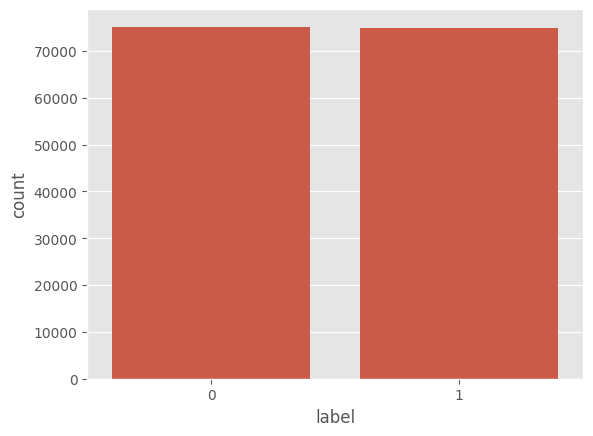

In [30]:
# 클래스 분포 확인 (0: 부정, 1: 긍정)
plt.style.use('ggplot')
sns.countplot(x='label', data=train_data)

<Axes: title={'center': 'Top 10 Train Words'}>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 45320 (\N{HANGUL SYLLABLE NEO}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 47568 (\N{HANGUL SYLLABLE MAL}) missing from current font.
  func(

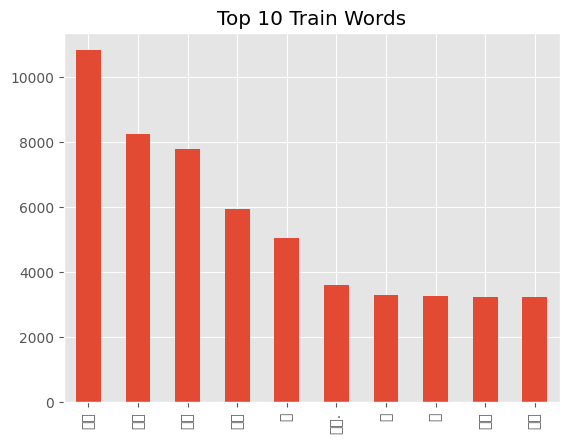

In [31]:
# 단어 빈도 분석 (train)
word_freq_train = train_data['document'].str.split(expand=True).stack().value_counts()
word_freq_train[:10].plot(kind='bar', title='Top 10 Train Words')

<Axes: title={'center': 'Top 10 Test Words'}>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 45320 (\N{HANGUL SYLLABLE NEO}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 47568 (\N{HANGUL SYLLABLE MAL}) missing from current font.
  func(

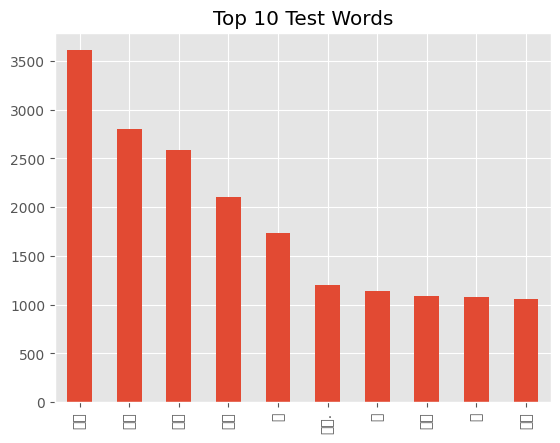

In [32]:
word_freq_test = test_data['document'].str.split(expand=True).stack().value_counts()
word_freq_test[:10].plot(kind='bar', title='Top 10 Test Words')

리뷰의 최대 길이 : 146
리뷰의 평균 길이 : 35.204526817560584


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44600 (\N{HANGUL SYLLABLE GIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages

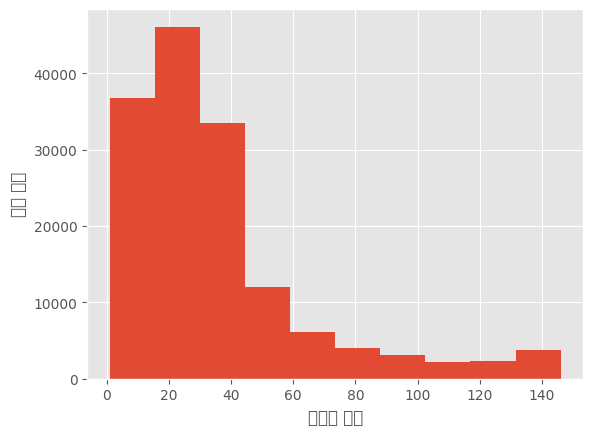

In [33]:
print('리뷰의 최대 길이 :', max([len(str(review)) for review in train_data['document']])) # 146
print('리뷰의 평균 길이 :', np.mean([len(str(review)) for review in train_data['document']])) # 35.20
plt.hist([len(str(review)) for review in train_data['document']])
plt.xlabel('문장의 길이')
plt.ylabel('샘플 개수')
plt.show()

# 토큰화 (Tokenizing)

## 결측값, 불용어 제거

In [34]:
# 결측값 확인
print('train_data 결측값: ', train_data['document'].isnull().sum())
print('test_data 결측값: ', test_data['document'].isnull().sum())

train_data 결측값:  0
test_data 결측값:  0


In [35]:
# 중복데이터 확인 -train
print('중복데이터 개수(train) :',train_data[train_data['document'].duplicated()].shape[0])
train_data[train_data['document'].duplicated()].head()

중복데이터 개수(train) : 3813


,id,document,label
1058,5890638,4,0
1097,2062443,쵝오,1
1248,3502685,최고,1
1483,775332,최고,1
1707,8009134,재밌다,1


In [36]:
# 중복데이터 확인 -test
print('중복데이터 개수(test) :',test_data[test_data['document'].duplicated()].shape[0])
test_data[test_data['document'].duplicated()].head()

중복데이터 개수(test) : 840


,id,document,label
857,2084375,bad,0
956,195683,재미있어요,1
1089,2235528,볼만함,1
1149,4409686,굿,1
1600,3805716,최고,1


In [37]:
# 중복 데이터 제거후 데이터 수
train_data.drop_duplicates(subset=['document'], inplace=True)
test_data.drop_duplicates(subset=['document'], inplace=True)

print('중복데이터 제거 후 train 데이터 수 :',train_data.shape[0])
print('중복데이터 제거 후 test 데이터 수 :',test_data.shape[0])

중복데이터 제거 후 train 데이터 수 : 146182
중복데이터 제거 후 test 데이터 수 : 49157


In [38]:
# 결측치 제거
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
test_data['document'] = test_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
test_data['document'].replace('', np.nan, inplace=True)

print('결측값 수(train) :', train_data['document'].isnull().sum())
print('결측값 수(test) :',test_data['document'].isnull().sum())

<ipython-input-38-7eaf880e0d0e>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


결측값 수(train) : 0
결측값 수(test) : 0


<ipython-input-38-7eaf880e0d0e>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


In [39]:
# 총 데이터 수
print('train :', train_data.shape[0])
print('test :', test_data.shape[0])

train : 146182
test : 49157


## Tokenizing

In [40]:
sp = spm.SentencePieceProcessor()
sp.load('/content/drive/MyDrive/Colab Notebooks/naver_review/naver_review.model')  # 모델 경로 설정

# 토크나이저 함수 정의
def tokenizer(text):
    return sp.encode_as_pieces(text)

In [42]:
# 데이터프레임 train_data에서 document 열을 기반으로 SentencePiece로 문장 토큰화
for i, (line) in enumerate(train_data['document']):
    # 출력: 현재 처리 중인 문장
    print(line)

    # 출력: SentencePiece를 사용하여 Subword로 토큰화한 결과
    print(sp.encode_as_pieces(line))

    # 출력: Subword를 ID로 매핑한 결과
    print(sp.encode_as_ids(line))
    if i == 5:
        break

아 더빙.. 진짜 짜증나네요 목소리
['▁아', '▁더빙', '..', '▁진짜', '▁짜증나', '네요', '▁목소리']
[14, 1226, 7, 88, 2990, 55, 2393]
흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
['▁흠', '...', '포스터', '보고', '▁초딩', '영화', '줄', '....', '오', '버', '연기', '조차', '▁가볍', '지', '▁않', '구나']
[1949, 16, 5829, 233, 1469, 10, 6601, 47, 6454, 6564, 355, 2103, 2338, 6387, 108, 508]
너무재밓었다그래서보는것을추천한다
['▁너무', '재', '밓', '었다', '그래서', '보는', '것을', '추천', '한다']
[39, 6416, 1, 164, 4556, 515, 1409, 2176, 367]
교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
['▁교', '도', '소', '▁이야기', '구', '먼', '▁..', '솔직히', '▁재미는', '▁없다', '..', '평점', '▁조', '정']
[729, 6392, 6487, 372, 6478, 6879, 516, 5346, 1686, 309, 7, 1187, 188, 6424]
사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다
['▁사이', '몬', '페', '그', '의', '▁익', '살', '스런', '▁연기가', '▁돋보', '였던', '▁영화', '!', '스', '파이', '더', '맨', '에서', '▁늙', '어', '보이', '기만', '▁했던', '▁커', '스', '틴', '▁던', '스트', '가', '▁너무나도', '▁이뻐', '보', '였다']
[2855, 7223, 6958, 6415, 6400, 3665, 6598, 2275, 776, 1967, 2639, 11, 6409, 6418, 2182, 6470, 6720, 62, 28

- 주어진 출력 결과는 각 문장에 대해 SentencePiece를 사용하여 Subword로 토큰화한 결과
- 각 문장에 대해
  - 원본 문장
  - Subword로 토큰화된 리스트
  - 각 토큰에 대한 ID 리스트가 출력되어 있